<a href="https://colab.research.google.com/github/TheAcoff/Notebook-Alura/blob/main/Machine_Learning/Otimiza%C3%A7%C3%A3o_de_Hiperpar%C3%A2metros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Otimização de Hiperparâmetros
- Exploração Manual
- GridSearchCV
- Decision Tree Classifier

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


Para testar, será gerado uma forma aleatória para testar um modelo

In [2]:
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


## Dummy Classifier

In [3]:
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


## Cross Validation

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


Gerando dados aleatórios para testar o modelo

In [5]:
np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

## GroupKFold
GroupKFold para analisar como o modelo se comporta com novos grupos


In [7]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


Visualizando uma árvore de decisão para entender como está funcionando.

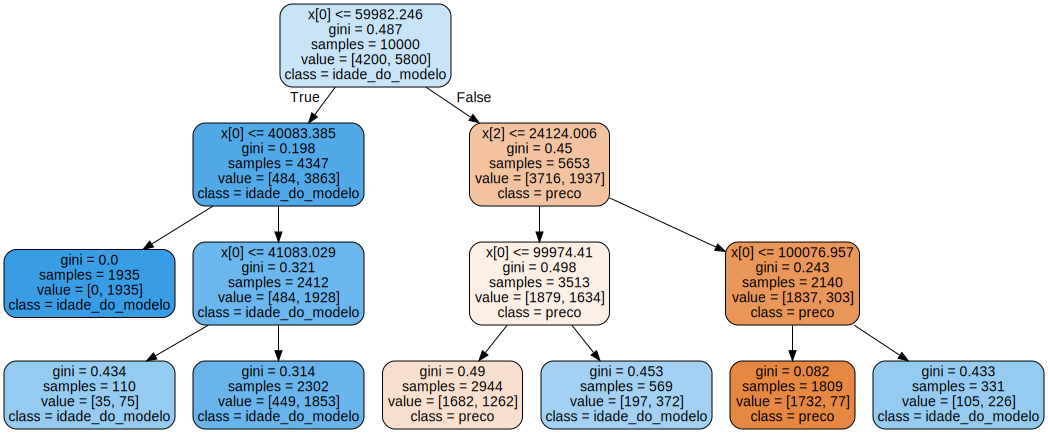

In [8]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True,
                class_names = features)

graph = graphviz.Source(dot_data)
graph

## Explorando hiperparâmetros

Mais camadas significa melhor precisão? Vamos testar

In [41]:
def arvore_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean()*100
  test_score = results['test_score'].mean()*100
  tabela = [max_depth, train_score, test_score]
  return tabela

resultados = [arvore_decisao(i) for i in range(1, 33)]
imprime_resultados = pd.DataFrame(resultados, columns=['max_depth', 'train_score', 'test_score'])
imprime_resultados.head()

,max_depth,train_score,test_score
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


<Axes: xlabel='max_depth', ylabel='train_score'>

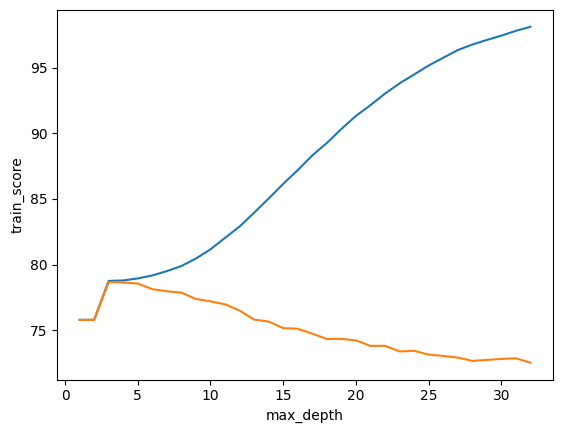

In [10]:
import seaborn as sns

sns.lineplot(x='max_depth', y='train_score', data=imprime_resultados)
sns.lineplot(x='max_depth', y='test_score', data=imprime_resultados)

In [11]:
imprime_resultados.sort_values('test_score', ascending=False).head()

,max_depth,train_score,test_score
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


### Hiperparâmetros de muitas dimensões
Essa é uma forma muito boa para decidir. Mas o que podemos fazer quando os processos de treino e teste são longos? Temos uma forma de otimizar o processo de otimização.



In [12]:
def arvore_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean()*100
  test_score = results['test_score'].mean()*100
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

resultados = []

def busca():
  for i in [1,4,32,44,252]:
    for j in [1,4,32,44,252]:
      resultados.append(arvore_decisao(i, j))
      imprime_resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
  return imprime_resultados

resultados = busca()
resultados.sort_values('test_score', ascending=False).head()

,max_depth,min_samples_leaf,train_score,test_score
7,4,32,78.750993,78.672633
8,4,44,78.750993,78.672633
9,4,252,78.750993,78.672633
5,4,1,78.787628,78.632803
6,4,4,78.766543,78.572937


Esse caso é interessante, mas podemos ter valores intermediários mais interessantes. Para isso, podemos ver a correlação dos dados para tentar entender o comportamento

<Axes: >

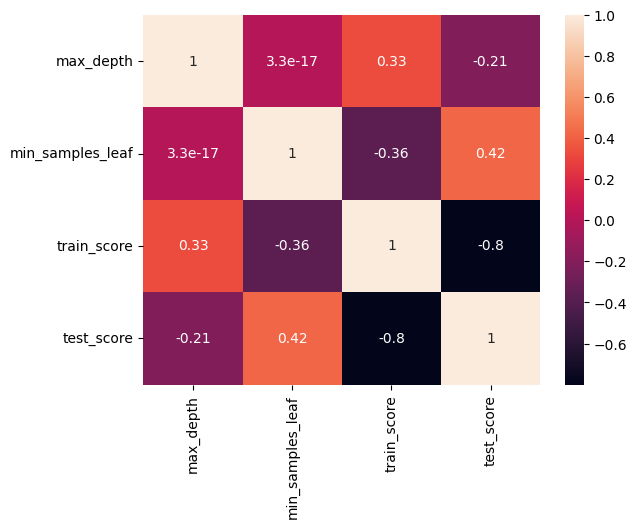

In [13]:
corr = resultados.corr()
sns.heatmap(corr, annot=True)

<Axes: >

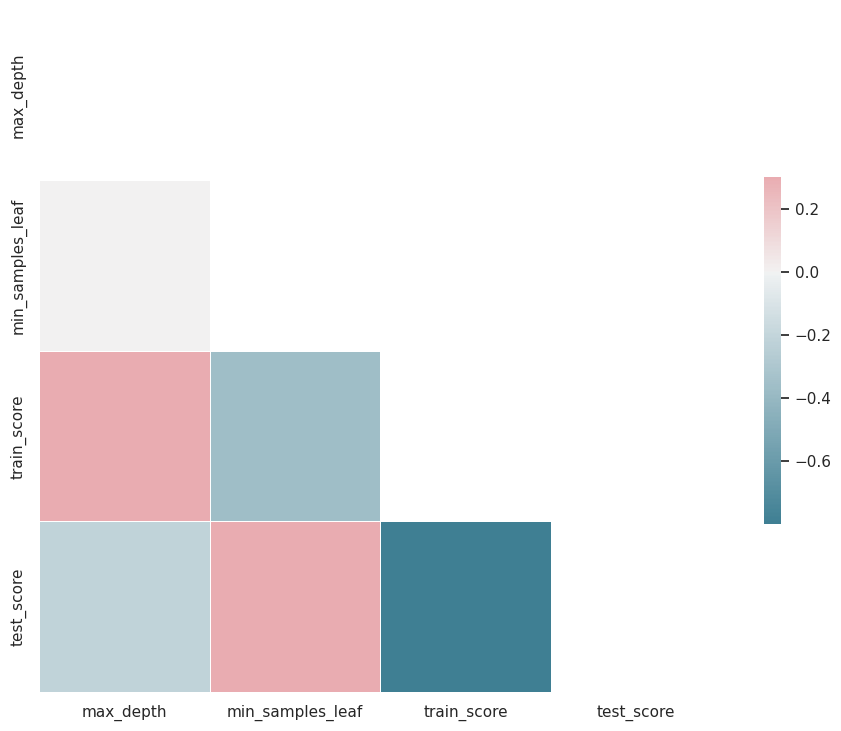

In [16]:
import matplotlib.pyplot as plt

sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Três ou mais Hiperparâmetros

In [17]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","min_samples_split","train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.006686,0.001695
1,1,32,64,75.791169,75.784219,0.006371,0.001673
2,1,32,128,75.791169,75.784219,0.007332,0.002020
3,1,32,256,75.791169,75.784219,0.006747,0.001892
4,1,64,32,75.791169,75.784219,0.006755,0.001803


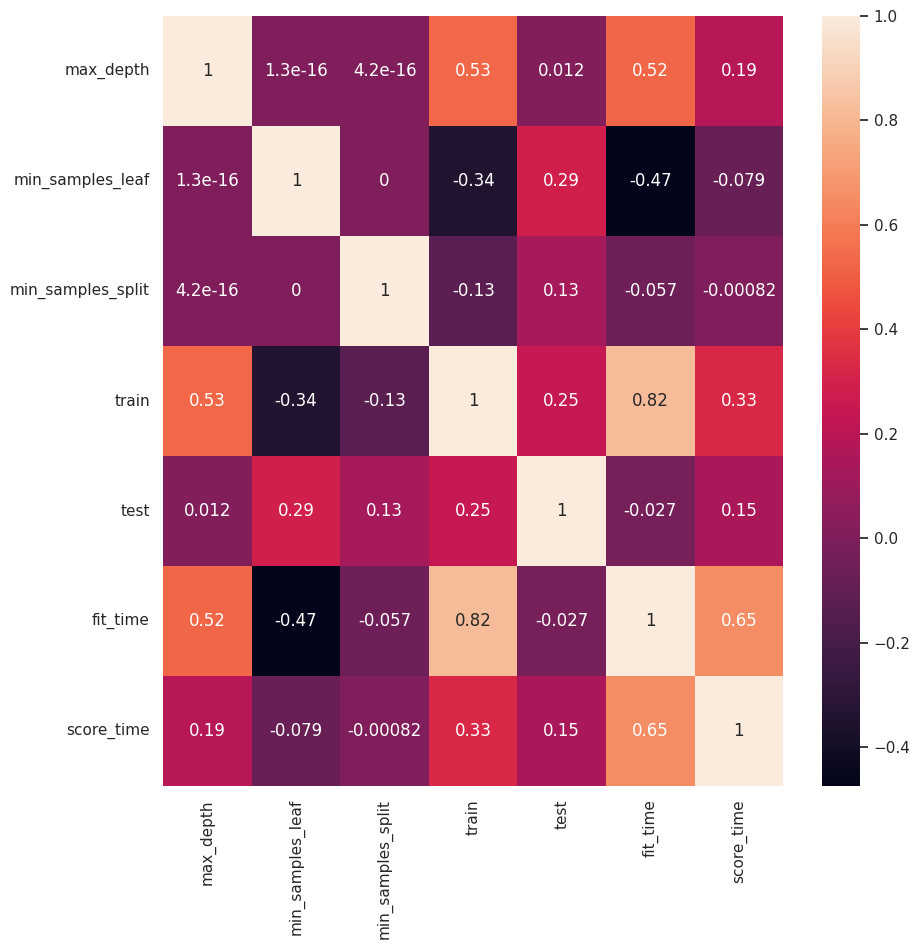

In [18]:
corr = resultados.corr()

ax, fig = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, annot=True)
plt.show()

## Usando GridSearchCV

In [20]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    'max_depth' : [3,5],
    'min_samples_split' : [32, 64, 128],
    'min_samples_leaf' : [32, 64, 128],
    'criterion' : ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014017,0.001617,0.002168,0.000433,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.013174,0.000312,0.001984,0.000108,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.013347,0.000518,0.002150,0.000226,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.013524,0.000799,0.002083,0.000196,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.013504,0.000741,0.002096,0.000113,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


podemos buscar os melhores parâmetros com

In [21]:
print(busca.best_params_)
print(busca.best_score_ *100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [24]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


In [32]:
from sklearn.metrics import accuracy_score
predicoes = melhor.predict(x_azar)
print(f'Acurácia: {accuracy_score(predicoes, y_azar) * 100} %')

Acurácia: 78.75 %


vamos evitar a abordagem anterior por ser muito otimista
## Estimativa sem os vícios

Usando *cv* com busca de hiperparametros, podemos fazer uma outra validação, chamada de nested cv.

Porém, primeiramente temos que rodar um KFold para evitar um bug antigo e não corrigido

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012766,0.000940,0.002240,0.000235,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.012012,0.000422,0.002078,0.000106,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.012330,0.000424,0.002424,0.000456,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.013020,0.001709,0.002111,0.000084,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.011930,0.000209,0.002081,0.000076,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [36]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits = 10), groups = dados.modelo)
scores


array([0.80475719, 0.79366701, 0.79331307, 0.7840796 , 0.78318136,
       0.79780876, 0.76286579, 0.78181818, 0.7755102 , 0.79026217])

In [37]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [38]:
imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


Sabendo os scores, podemos visualizar o melhor modelo

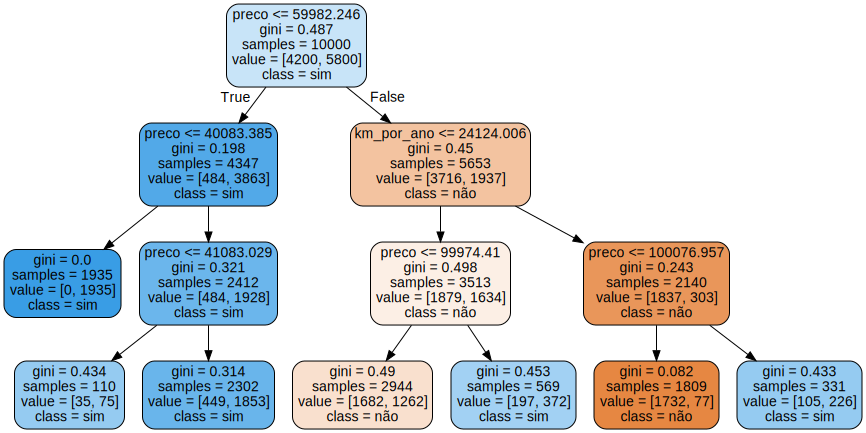

In [40]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

---
# 2. Exploração Aleatória